results

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import sys
import os

# Dodanie ścieżki głównej projektu, aby móc importować z folderu 'src'
root_path = Path.cwd().parent
sys.path.append(str(root_path))

from src.quantum_model import QuantumRiskModel
from src.utils import prepare_quantum_data

# Definicja ścieżek do danych
weights_path = root_path / "data" / "quantum_weights.npy"
data_path = root_path / "data" / "features_ml_data.csv"

print(f"Katalog projektu: {root_path}")

Katalog projektu: C:\Users\karol\PycharmProjects\Quantum-Risk-Scoring


In [11]:
# 1. Inicjalizacja modelu (musi być identyczny jak w treningu)
n_qubits = 4
q_model = QuantumRiskModel(n_qubits=n_qubits, n_layers=3)

# 2. Wczytanie wag
if weights_path.exists():
    payload = np.load(weights_path, allow_pickle=True).item()

    trained_weights = payload['weights']
    trained_bias = payload['bias']
    print("✅ Wagi modelu wczytane pomyślnie.")
else:
    raise FileNotFoundError(f"Nie znaleziono pliku wag w {weights_path}")

# 3. Przygotowanie danych testowych
X_train, X_test, y_train, y_test = prepare_quantum_data(str(data_path), n_components=n_qubits)
print(f"✅ Dane testowe przygotowane. Rozmiar: {X_test.shape}")

✅ Wagi modelu wczytane pomyślnie.
✅ Dane testowe przygotowane. Rozmiar: (248, 4)


C:\Users\karol\PycharmProjects\Quantum-Risk-Scoring\src\utils.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Target'] = pd.qcut(df[vol_col], 4, labels=[0, 1, 2, 3]).astype(int)


In [12]:
# Wybieramy liczbę próbek do wizualizacji (symulacja kwantowa wymaga czasu)
num_samples = 50

print(f"Generowanie predykcji dla {num_samples} dni rynkowych...")
q_preds = []
actuals = []

for i in range(num_samples):
    # Wykonanie predykcji przez obwód kwantowy
    prediction = q_model.predict(trained_weights, trained_bias, X_test[i])

    q_preds.append(int(prediction))
    actuals.append(int(y_test[i]))

print("✅ Predykcje zakończone.")

Generowanie predykcji dla 50 dni rynkowych...
✅ Predykcje zakończone.


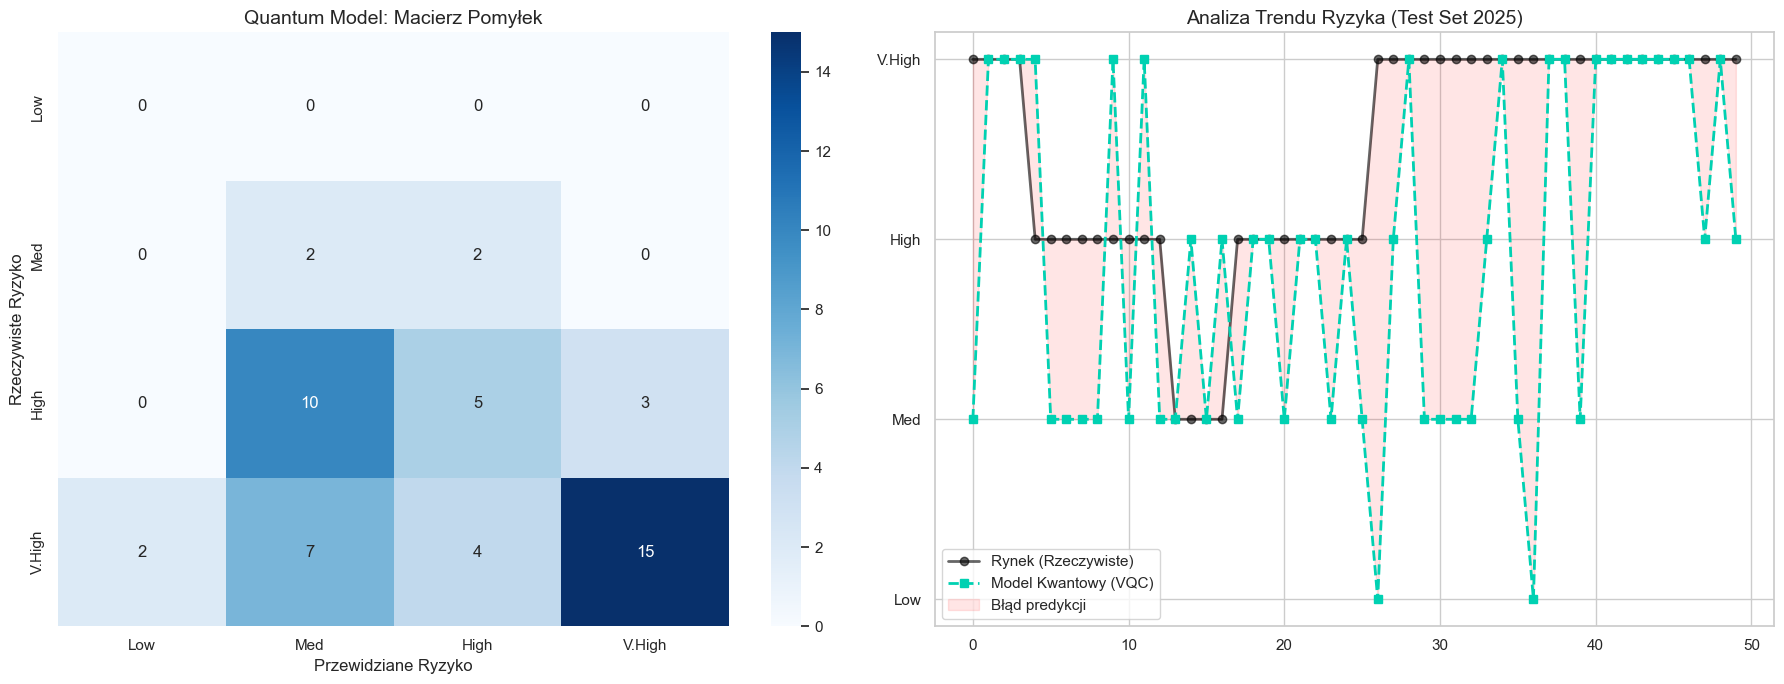

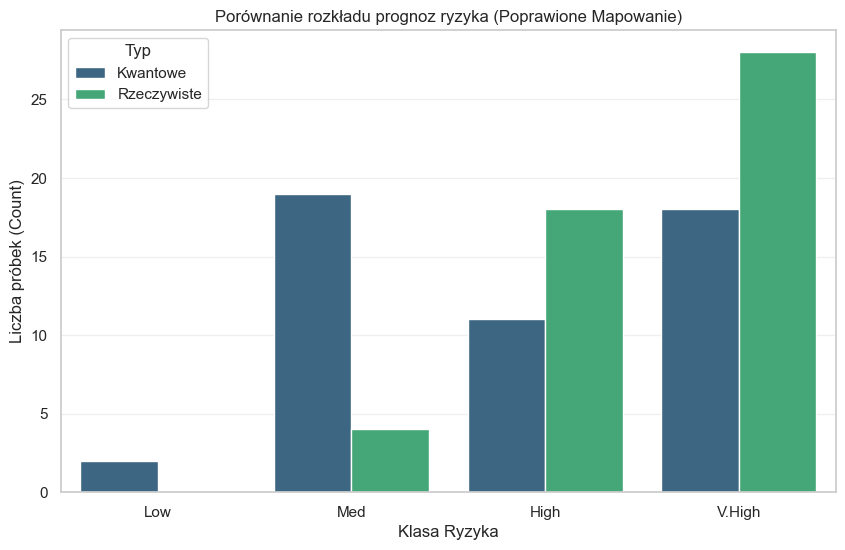


SZCZEGÓŁOWY RAPORT KLASYFIKACJI:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         0
         Med       0.11      0.50      0.17         4
        High       0.45      0.28      0.34        18
      V.High       0.83      0.54      0.65        28

    accuracy                           0.44        50
   macro avg       0.35      0.33      0.29        50
weighted avg       0.64      0.44      0.50        50



In [13]:
# Ustawienia stylu wykresów
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- WYKRES 1: Macierz Pomyłek ---
cm = confusion_matrix(actuals, q_preds, labels=[0, 1, 2, 3])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Low', 'Med', 'High', 'V.High'],
            yticklabels=['Low', 'Med', 'High', 'V.High'])
axes[0].set_title('Quantum Model: Macierz Pomyłek', fontsize=14)
axes[0].set_ylabel('Rzeczywiste Ryzyko', fontsize=12)
axes[0].set_xlabel('Przewidziane Ryzyko', fontsize=12)

# --- WYKRES 2: Porównanie Szeregów Czasowych ---
axes[1].plot(actuals, label='Rynek (Rzeczywiste)', color='black', linewidth=2, marker='o', alpha=0.6)
axes[1].plot(q_preds, label='Model Kwantowy (VQC)', color='#00d1b2', linewidth=2, linestyle='--', marker='s')
axes[1].fill_between(range(len(q_preds)), actuals, q_preds, color='red', alpha=0.1, label='Błąd predykcji')

axes[1].set_yticks([0, 1, 2, 3])
axes[1].set_yticklabels(['Low', 'Med', 'High', 'V.High'])
axes[1].set_title('Analiza Trendu Ryzyka (Test Set 2025)', fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.show()

# --- WYKRES 3: Rozkład Klas ---
plt.figure(figsize=(10, 6))

# Przygotowanie danych do wykresu słupkowego
df_compare = pd.DataFrame({'Rzeczywiste': actuals, 'Kwantowe': q_preds})
df_melted = df_compare.melt(var_name='Typ', value_name='Klasa Ryzyka')

# Definiujemy stałą kolejność klas, aby uniknąć przesuwania słupków
risk_order = [0, 1, 2, 3]
risk_labels = ['Low', 'Med', 'High', 'V.High']

# Tworzymy wykres z wymuszoną listą kategorii (order)
sns.countplot(data=df_melted, x='Klasa Ryzyka', hue='Typ',
              palette='viridis', order=risk_order)

# Poprawiamy etykiety na osi X, aby zawsze odpowiadały właściwym klasom
plt.xticks(ticks=range(4), labels=risk_labels)

plt.title('Porównanie rozkładu prognoz ryzyka (Poprawione Mapowanie)')
plt.ylabel('Liczba próbek (Count)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- RAPORT TEKSTOWY ---
print("\nSZCZEGÓŁOWY RAPORT KLASYFIKACJI:")
# Dodajemy parametr labels=[0, 1, 2, 3], aby wymusić strukturę raportu
print(classification_report(
    actuals,
    q_preds,
    labels=[0, 1, 2, 3],
    target_names=['Low', 'Med', 'High', 'V.High'],
    zero_division=0
))